In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tabulate import tabulate
import duckdb

In [241]:
data = pd.read_csv('/Users/Rui/Desktop/phd/y_intercept/data.csv')
data = pd.DataFrame(data)
data

market = pd.read_csv('/Users/Rui/Desktop/phd/y_intercept/N225.csv')
market = pd.DataFrame(market)
market

data = pd.merge(data, market[['Adj Close', 'Date']], left_on='date', right_on='Date')
data.drop(['Date'], axis=1, inplace=True)
data.rename(columns={'last': 'prc'}, inplace=True)

data

,ticker,date,prc,volume,Adj Close
0,1332 JT,2013-01-04,169.0987,1464100,10688.110352
1,1334 JT,2013-01-04,147.8887,1553000,10688.110352
2,1605 JT,2013-01-04,970.6780,5312400,10688.110352
3,1721 JT,2013-01-04,950.5521,816600,10688.110352
4,1801 JT,2013-01-04,1232.0186,2254000,10688.110352
...,...,...,...,...,...
451108,9613 JT,2021-03-19,1723.0000,7315700,29792.050781
451109,9735 JT,2021-03-19,9594.0000,820300,29792.050781
451110,9766 JT,2021-03-19,6850.0000,870300,29792.050781
451111,9983 JT,2021-03-19,91020.0000,1542800,29792.050781


In [14]:
min(data['last'])

63.0

In [11]:
len(set(data['ticker']))

248

In [13]:
data['last'].isnull().sum()

0

In [100]:
data['date'].min(), data['date'].max()

('2013-01-04', '2021-03-19')

In [242]:
'''
- 805,090 observations based on monthly return data from July 1997 to December 2012
- observations must have a one year history of past stock return data to compute momentum variables, 
- must have a stock price in the preceding month that is greater than one dollar. 
'''
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['prc_lag1'] = data.groupby('ticker')['prc'].shift(1)
data['vol_lag1'] = data['volume'].shift(1)
data['ret'] = data.groupby('ticker')['prc'].pct_change()
data['mkt'] = data.groupby('ticker')['Adj Close'].pct_change()

def rolling_prod(a, n=30) :
    ret = np.cumprod(a.values)
    ret[n:] = ret[n:] / ret[:-n]
    ret[:n-1] = np.nan
    return pd.Series(ret, index=a.index)


data['momentum'] = (
    data
    .assign(ret=(data['ret'].fillna(0)+1))
    .groupby('ticker')['ret']
    .apply(rolling_prod)
) - 1


data.dropna(inplace=True)

def apply_quantiles(x, include_in_quantiles=None, bins=10): 
    x = pd.Series(x)
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)        
    
    quantiles = np.quantile(
        np.unique(x[x.notnull() & include_in_quantiles]),
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.dropna().min() - 1
    quantiles[-1] = x.dropna().max() + 1    
    return pd.cut(x, quantiles, labels=False) + 1



def make_portfolio(df): 
    
    portfolios = (
        df[
            df['bin'].notnull() &
            df['ret'].notnull() 
        ]
        .groupby(['bin', 'date'])[['ret', 'vol_lag1']]
        .apply(
            lambda g: pd.Series({
                'ew': g['ret'].mean(),
                'vw': np.average(g['ret'], weights=g['vol_lag1'])
            })
        )
        .reset_index()
    )

    portfolio_LS = (
        portfolios[portfolios['bin'].isin(set([1, 10]))]
        .groupby('date')
        .apply(
            lambda g: pd.Series({
                'ew': np.sum(np.where(g['bin']==1, -g['ew'], g['ew'])),
                'vw': np.sum(np.where(g['bin']==1, -g['vw'], g['vw']))
            })
        )
        .reset_index()
    )
        
    portfolio_LS = portfolio_LS.sort_values('date').reset_index(drop=True)
    portfolio_LS['cum_ew'] = (portfolio_LS['ew'] + 1).cumprod()
    portfolio_LS['cum_vw'] = (portfolio_LS['vw'] + 1).cumprod()


    return portfolio_LS


/var/folders/4p/lng78s416xs7hybsq7jh6lqm0000gn/T/ipykernel_15452/487009957.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data


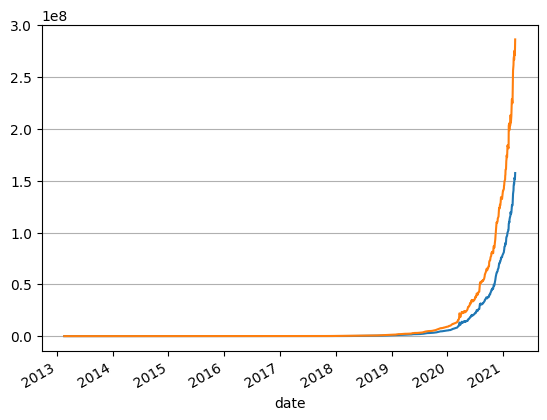

In [266]:
data['bin'] = (
    data
    .groupby('date')
    .apply(lambda group: apply_quantiles(group['momentum'], bins=10))
).reset_index(level=[0], drop=True).sort_index()

portfolio = make_portfolio(data)
portfolio.set_index('date')['cum_ew'].plot().grid(axis='y')
portfolio.set_index('date')['cum_vw'].plot().grid(axis='y')

In [97]:
def vol(ret):
    annual_volatility = np.std(ret) * np.sqrt(252)
    return annual_volatility

def sharpe(ret, rf=0.03):
    excess_returns = np.array(ret) - rf
    sharpe_ratio = (np.mean(excess_returns) / vol(ret)) if vol(ret) != 0 else 0
    return sharpe_ratio

def max_drawdown(ret):
    cum_ret = np.cumprod(1 + ret)
    peak = cum_ret.cummax()
    trough = cum_ret.cummin()
    drawdown = (peak - trough) / peak
    max_drawdown = drawdown.max()
    return max_drawdown

def obs(ret):
    metrics = [
        ["Maximum Drawdown", max_drawdown(ret)],
        ["Annualized Volatility", vol(ret)],
        ["Sharpe Ratio", sharpe(ret)],
    ]

    table = tabulate(metrics, headers=["Metric", "Value"], tablefmt="pretty")
    print(table)

obs(portfolio['cum_ew'])
obs(portfolio['cum_vw'])

+-----------------------+---------------------+
|        Metric         |        Value        |
+-----------------------+---------------------+
|   Maximum Drawdown    |         1.0         |
| Annualized Volatility | 110117592.43501434  |
|     Sharpe Ratio      | 0.02076048935328187 |
+-----------------------+---------------------+
+-----------------------+----------------------+
|        Metric         |        Value         |
+-----------------------+----------------------+
|   Maximum Drawdown    |         1.0          |
| Annualized Volatility |  41560470.563807465  |
|     Sharpe Ratio      | 0.021602102956220625 |
+-----------------------+----------------------+


/Users/Rui/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
